In [1]:
import os

import nibabel as nib
import scipy.ndimage as ndi
from matplotlib import pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'nibabel'

In [2]:
brain_data_dir = "../assets/source_images"
!dir

 Volume in drive C has no label.
 Volume Serial Number is B4D0-A45D

 Directory of c:\Work\Study\Semester 1\ENSF 619\Final Project\Scripts

2024-03-24  12:47 PM    <DIR>          .
2024-03-17  12:52 AM    <DIR>          ..
2024-03-24  12:48 PM    <DIR>          .idea
2024-03-24  12:51 PM         1,916,343 analye_images.ipynb
2024-03-24  12:37 PM            88,096 basic_unet.ipynb
2024-03-17  12:52 AM        11,350,784 brain.stl
2024-03-24  12:47 PM           136,375 create_image_slices.ipynb
2024-03-21  05:06 PM                54 requirements.txt
2024-03-17  12:52 AM        17,872,484 skull_w_jaw.stl
2024-03-18  04:12 PM        89,653,600 test.nii
2024-03-24  12:42 PM               647 test.py
2024-03-18  08:52 PM             8,234 test_image_slice.jpg
2024-03-21  03:56 PM    <DIR>          test_image_slices
2024-03-18  08:53 PM            17,321 test_image_slice_cv.jpg
2024-03-18  08:58 PM            16,412 test_image_slice_cv_scaled.jpg
2024-03-21  05:43 PM    <DIR>          venv
   

In [146]:
images = os.listdir(brain_data_dir)

In [147]:
print(len(images))

359


In [148]:
images[0]

'CC0001_philips_15_55_M_staple.nii'

In [149]:
first_image = nib.load(os.path.join(brain_data_dir, images[0]))

In [150]:
print(first_image.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 171 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         0.99999815 1.         1.         1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0005584752
quatern_c       : 0.032486536
quatern_d       : -0.031978097
qoffset_x       : -96.71713
qoffset_y   

In [151]:
image_data = first_image.get_fdata()

In [152]:
image_data.shape

(171, 256, 256)

In [153]:
image_data[:, :, 0].shape

(171, 256)

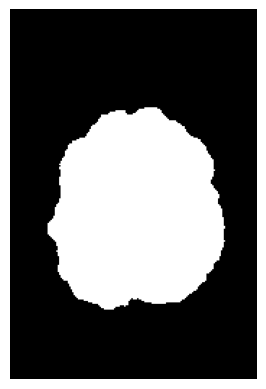

In [154]:
image_array = ndi.rotate(image_data[:, :, 160], 90)

plt.imshow(image_array, cmap='gray')
plt.axis("off")
plt.show()

Add 3d augmentation

In [12]:
def translate_3d_image(image, translation_range):
    translation_value = np.random.randint(-translation_range, translation_range)
    translated_image = np.roll(image, translation_value, axis=(0, 1, 2))
    
    print(f"Translated for {translation_value} pixels")
    
    return translated_image
    

In [13]:
def rotate_3d_image(image, rotation_angle):
    rot_x, rot_y, rot_z = np.random.uniform(-rotation_angle, rotation_angle, size=3)
    
    rot_x_image = ndi.rotate(image, rot_x, mode='nearest', axes=(1, 2), reshape=False)
    rot_y_image = ndi.rotate(rot_x_image, rot_y, mode='nearest', axes=(0, 2), reshape=False)
    rot_z_image = ndi.rotate(rot_y_image, rot_z, mode='nearest', axes=(0, 1), reshape=False)
    
    print(f"Rotated {rot_x} degrees in x axis")
    print(f"Rotated {rot_y} degrees in y axis")
    print(f"Rotated {rot_z} degrees in z axis")
    
    return rot_z_image
    

In [14]:
def augment_3d_image(image, thresh_translation, thresh_rotation_angle):
    translated_3d_image = translate_3d_image(image, thresh_translation)
    rotated_3d_image = rotate_3d_image(translated_3d_image, thresh_rotation_angle)
    
    return rotated_3d_image

In [15]:
def save_3d_image_as_nifti(image, filename):
    nifti_image = nib.Nifti1Image(image, affine=np.eye(4))
    
    nib.save(nifti_image, filename)

In [16]:
augmented_3d_image = augment_3d_image(image_data, 10, 5)

Translated for -10 pixels
Rotated -1.1199548664050498 degrees in x axis
Rotated 0.9677149082603531 degrees in y axis
Rotated -1.202583150984704 degrees in z axis


In [17]:
save_3d_image_as_nifti(augmented_3d_image, "test.nii")

In [18]:
def plot_subplots(plots, rows, cols, axis = "off"):
    fig, ax = plt.subplots(rows, cols, figsize=(10, 12), squeeze=False)
    
    for row in range(rows):
        for col in range(cols):
            ax[row, col].imshow(plots[row + col], cmap="gray")
            ax[row, col].axis(axis)
    
    plt.show()

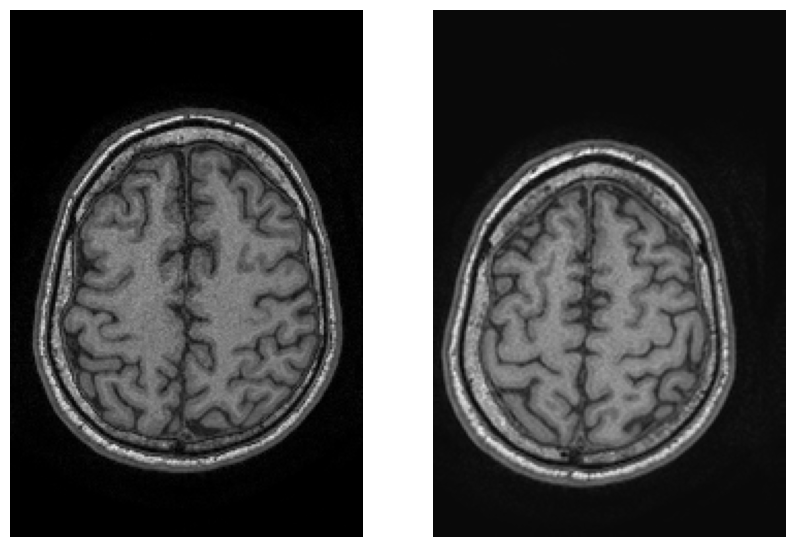

In [19]:
image_slices = [ndi.rotate(image_data[:, :, 160], 90), ndi.rotate(augmented_3d_image[:, :, 160], 90)]

plot_subplots(image_slices, 1, 2)

See fourier domain representations

In [20]:
def get_fourier_image(image_slice):
    f_image = np.fft.fft2(image_slice)
    f_image = np.fft.fftshift(f_image)
    
    return f_image

In [21]:
def get_spatial_image_from_fourier_image(fourier_image_slice):
    s_image = np.fft.ifftshift(fourier_image_slice)
    s_image = np.fft.ifft2(s_image)
    
    return s_image.real

In [22]:
f_image_slice_original = get_fourier_image(ndi.rotate(image_data[:, :, 160], 90))
f_image_slice_augmented = get_fourier_image(ndi.rotate(augmented_3d_image[:, :, 160], 90))

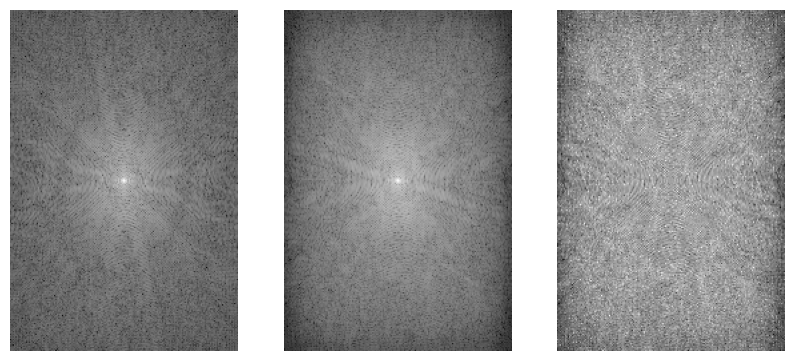

In [23]:
plot_subplots([np.log(1 + np.abs(f_image_slice_original)), np.log(1 + np.abs(f_image_slice_augmented)), np.log(1 + np.abs(f_image_slice_augmented)) - np.log(1 + np.abs(f_image_slice_original))], 1, 3)

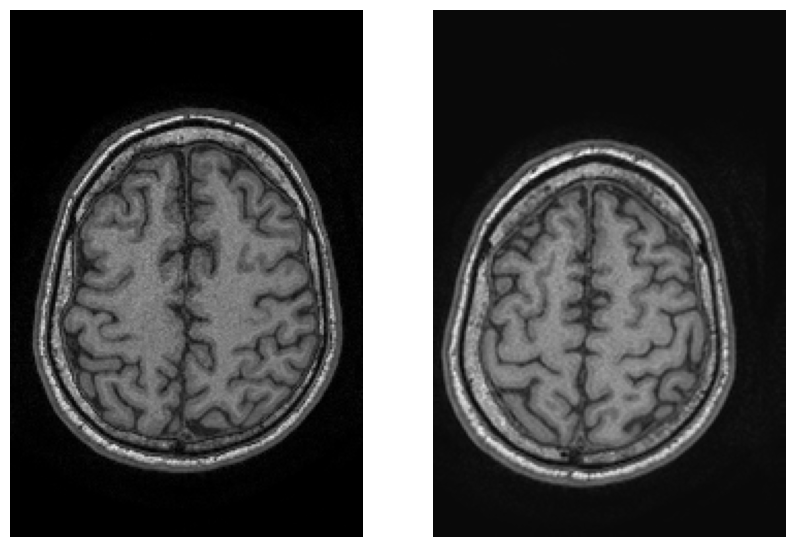

In [24]:
plot_subplots([get_spatial_image_from_fourier_image(f_image_slice_original), get_spatial_image_from_fourier_image(f_image_slice_augmented)], 1, 2)

Add noises in the fourier domain

In [25]:
# Get 3 augmented 3d images

augmented_3d_image_1 = augment_3d_image(image_data, 10, 5)
augmented_3d_image_2 = augment_3d_image(augmented_3d_image_1, 10, 5)
augmented_3d_image_3 = augment_3d_image(augmented_3d_image_2, 10, 5)

Translated for -3 pixels
Rotated -1.4629250172134602 degrees in x axis
Rotated 0.5229036653357664 degrees in y axis
Rotated 3.4510225101862186 degrees in z axis
Translated for -1 pixels
Rotated 1.8526715136833136 degrees in x axis
Rotated 4.435389726768889 degrees in y axis
Rotated 2.6169560256254076 degrees in z axis
Translated for -3 pixels
Rotated -4.885065231657992 degrees in x axis
Rotated -1.1755881291233559 degrees in y axis
Rotated -0.6638969421403527 degrees in z axis


In [26]:
# Get the specific slice for each images

original_image_slice = ndi.rotate(image_data[:, :, 160], 90)
augmented_3d_image_1_slice = ndi.rotate(augmented_3d_image_1[:, :, 160], 90)
augmented_3d_image_2_slice = ndi.rotate(augmented_3d_image_2[:, :, 160], 90)
augmented_3d_image_3_slice = ndi.rotate(augmented_3d_image_3[:, :, 160], 90)

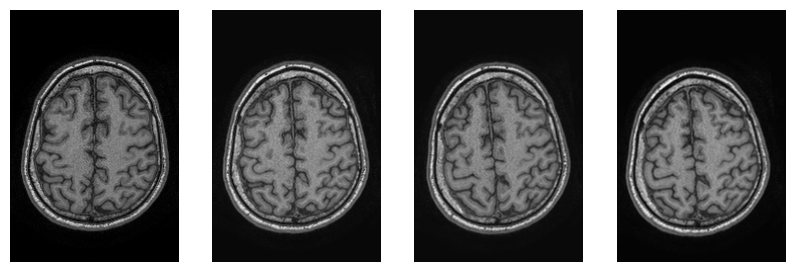

In [27]:
plot_subplots([original_image_slice, augmented_3d_image_1_slice, augmented_3d_image_2_slice, augmented_3d_image_3_slice], 1, 4)

In [28]:
# Get the fourier domain representation for each of the slices

f_original_image_slice = get_fourier_image(original_image_slice)
f_augmented_3d_image_1_slice = get_fourier_image(augmented_3d_image_1_slice)
f_augmented_3d_image_2_slice = get_fourier_image(augmented_3d_image_2_slice)
f_augmented_3d_image_3_slice = get_fourier_image(augmented_3d_image_3_slice)

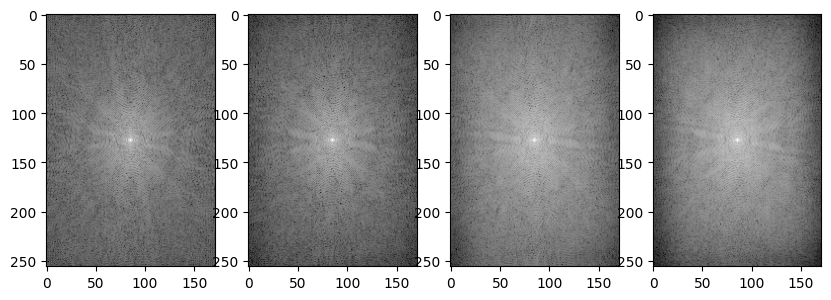

In [29]:
plot_subplots([np.log(1 + np.abs(f_original_image_slice)), np.log(1 + np.abs(f_augmented_3d_image_1_slice)), np.log(1 + np.abs(f_augmented_3d_image_2_slice)), np.log(1 + np.abs(f_augmented_3d_image_3_slice))], 1, 4, axis="on")

In [139]:
f_aggregated_scan = f_original_image_slice.copy()
f_aggregated_scan[50:90, :] = f_augmented_3d_image_1_slice[50:90, :]
f_aggregated_scan[160:185, :] = f_augmented_3d_image_2_slice[160:185, :]
f_aggregated_scan[220: 245, :] = f_augmented_3d_image_3_slice[220:245, :]

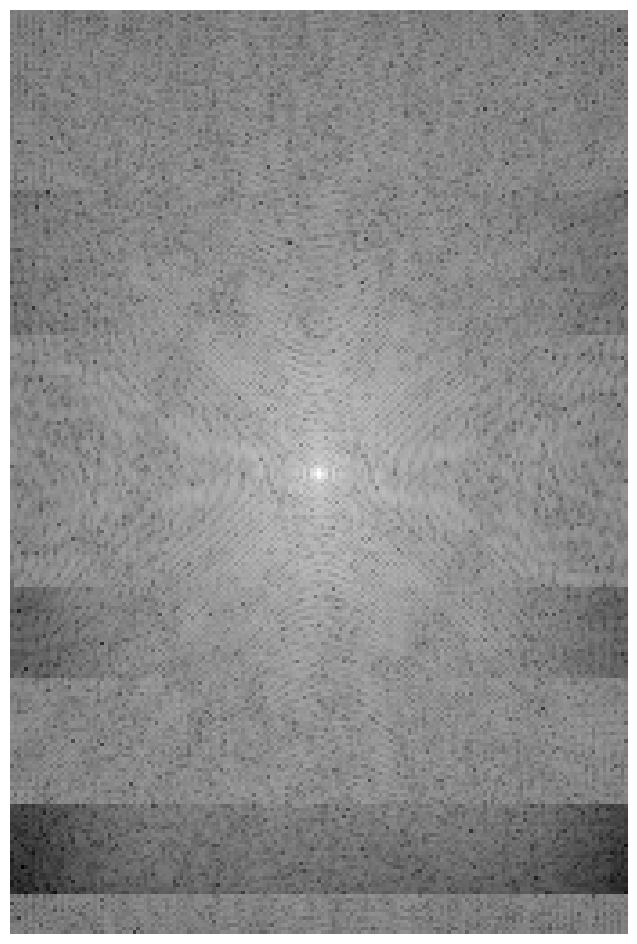

In [140]:
plot_subplots([np.log(1 + np.abs(f_aggregated_scan))], 1, 1)

In [141]:
aggregated_scan = get_spatial_image_from_fourier_image(f_aggregated_scan)

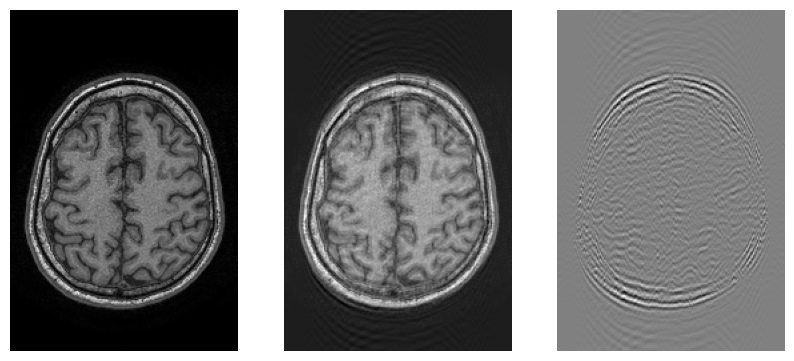

In [143]:
plot_subplots([original_image_slice, aggregated_scan, aggregated_scan - original_image_slice], 1, 3)